In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [75]:
from keras.models import Model
from keras import layers
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers

In [3]:
train = pd.read_csv('train.csv', low_memory=False)
train_id = pd.read_csv('train.csv', low_memory=False, usecols = ['id'])
test_id  = pd.read_csv('test.csv', low_memory=False, usecols = ['id'])
train_target = pd.read_csv('train.csv', usecols = ['target'])
embedding_matrix = pd.read_csv('data_process/embedding_matrix100d').values

In [4]:
totaldata = pd.read_csv('data_process/totaldata.csv',low_memory=False)

In [5]:
totaldata.shape

(10876, 56)

In [6]:
del totaldata['text']
del totaldata['keyword']
del totaldata['location']
del totaldata['id']

In [7]:
train = totaldata[totaldata['target'] != 2]
test = totaldata[totaldata['target'] == 2]

In [8]:
del train['target']
del test['target']

In [9]:
f_num = train.shape[1]

In [10]:
num_words = embedding_matrix.shape[0]
e_num = embedding_matrix.shape[1]

In [11]:
test.isna().any().any(), train.isna().any().any()

(False, False)

In [12]:
totaldata.columns

Index(['target', 'keyword_metric', 'domain_metric_mean', 'domain_metric_std',
       'domain_metric_max', 'domain_metric_min', 'textsize',
       'punctuation_count', 'word_mean_len', 'haslocacion', 'word_count',
       'upper_count', 'white_count', 'url_count', 'hashtag_count',
       'mention_count', 'PRP$', 'NNS', 'VBP', 'DT', 'NNP', 'IN', 'NN', 'PRP',
       'VBD', 'TO', 'VB', 'VBG', 'VBN', 'JJ', 'CC', 'RB', 'VBZ', 'MD', 'EX',
       'CD', 'WP', 'RP', 'NNPS', 'JJR', 'WRB', 'JJS', 'WDT', 'RBR', 'RBS',
       'FW', 'PDT', 'POS', 'UH', 'SYM', 'WP$', ''''],
      dtype='object')

In [13]:
pickle_in = open("data_process/tweet_pad100d.pickle","rb")
tweet_pad = pickle.load(pickle_in)

In [14]:
embedd_train =tweet_pad[:train.shape[0]]
embedd_test=tweet_pad[train.shape[0]:]

In [15]:
embedd_train.shape, embedd_test.shape, train.shape, test.shape

((7613, 100), (3263, 100), (7613, 51), (3263, 51))

In [16]:
embedd_test = pd.DataFrame(embedd_test)
embedd_train = pd.DataFrame(embedd_train)

In [17]:
test.reset_index(inplace=True)
test = test.drop('index',axis=1)

In [18]:
scaled = MinMaxScaler()
train = pd.DataFrame(scaled.fit_transform(train), columns= train.columns)
test = pd.DataFrame(scaled.fit_transform(test), columns= test.columns)

In [19]:
train.columns

Index(['keyword_metric', 'domain_metric_mean', 'domain_metric_std',
       'domain_metric_max', 'domain_metric_min', 'textsize',
       'punctuation_count', 'word_mean_len', 'haslocacion', 'word_count',
       'upper_count', 'white_count', 'url_count', 'hashtag_count',
       'mention_count', 'PRP$', 'NNS', 'VBP', 'DT', 'NNP', 'IN', 'NN', 'PRP',
       'VBD', 'TO', 'VB', 'VBG', 'VBN', 'JJ', 'CC', 'RB', 'VBZ', 'MD', 'EX',
       'CD', 'WP', 'RP', 'NNPS', 'JJR', 'WRB', 'JJS', 'WDT', 'RBR', 'RBS',
       'FW', 'PDT', 'POS', 'UH', 'SYM', 'WP$', ''''],
      dtype='object')

In [21]:
test = pd.concat([test,embedd_test],axis=1)
train = pd.concat([train,embedd_train],axis=1)

In [22]:
train.isna().any().any() , test.isna().any().any()

(False, False)

In [37]:
features_input = layers.Input(shape=(f_num,), name="features")
x = layers.Dense(512, activation='relu')(features_input)
x = layers.Dropout(0.1)(x)
features_output = layers.Dropout(0.2)(x)

emb_input = layers.Input(shape=(None,), name="embedd")
x = layers.Embedding(num_words,e_num,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=e_num,trainable=False)(emb_input)
x = layers.SpatialDropout1D(0.08)(x)
x = layers.Conv1D(512, 7, padding="valid", activation='relu', strides=4)(x)
x = layers.Dropout(0.1)(x)
emb_output = layers.GlobalMaxPooling1D()(x)

#x = layers.GRU(128,dropout=0.1,recurrent_dropout=0.08,return_sequences=True)(x)

x = layers.concatenate([features_output, emb_output])
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32,activation='relu')(x)
x = layers.Dropout(0.12)(x)
x = layers.Dense(6,activation='relu')(x)
x = layers.Dropout(0.14)(x)
conv1d = layers.Dense(1, activation='sigmoid')(x)

model4 = Model(
    inputs=[features_input,emb_input],
    outputs=[conv1d],
)
#optimzer = SGD(learning_rate=1e-5, momentum=0.8)
optimzer=Adam(learning_rate=1e-5)
model4.compile(
    loss='binary_crossentropy',
    optimizer=optimzer,
    metrics=['accuracy']
)

In [77]:
features_input = layers.Input(shape=(f_num,), name="features")
x = layers.Dense(256, activation='relu')(features_input)
x = layers.Dropout(0.1)(x)
features_output = layers.Dropout(0.2)(x)

emb_input = layers.Input(shape=(None,), name="embedd")
x = layers.Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=e_num)(emb_input)
x = layers.Bidirectional(layers.LSTM(100, return_sequences = True, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.01)))(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.BatchNormalization()(x)
emb_output = layers.Dropout(0.3)(x)

#x = layers.GRU(128,dropout=0.1,recurrent_dropout=0.08,return_sequences=True)(x)

x = layers.concatenate([features_output, emb_output])
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(24,activation='relu')(x)
x = layers.Dropout(0.12)(x)
x = layers.Dense(6,activation='relu')(x)
x = layers.Dropout(0.14)(x)
conv1d = layers.Dense(1, activation='sigmoid')(x)

model4 = Model(
    inputs=[features_input,emb_input],
    outputs=[conv1d],
)
#optimzer = SGD(learning_rate=1e-5, momentum=0.8)
optimzer=Adam(learning_rate=1e-5)
model4.compile(
    loss='binary_crossentropy',
    optimizer=optimzer,
    metrics=['accuracy']
)

In [78]:
#model4.summary()

In [79]:
#early_stop = EarlyStopping(
#    monitor='val_accuracy',
#    patience=6)

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

In [88]:
history=model4.fit(
    {"features": train.values[:,:f_num], "embedd": train.values[:,f_num:]},
    train_target.values,
    batch_size=10,
    epochs=100,
    validation_split=0.2,
    verbose=1,
   callbacks=[reduce_lr,checkpoint]
)

Epoch 1/100
609/609 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.8131
Epoch 00001: val_loss improved from 0.93882 to 0.92497, saving model to model.h5
609/609 [==============================] - 87s 142ms/step - loss: 0.9603 - accuracy: 0.8131 - val_loss: 0.9250 - val_accuracy: 0.8313
Epoch 2/100
609/609 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.8284
Epoch 00002: val_loss improved from 0.92497 to 0.91231, saving model to model.h5
609/609 [==============================] - 86s 141ms/step - loss: 0.9342 - accuracy: 0.8284 - val_loss: 0.9123 - val_accuracy: 0.8332
Epoch 3/100
609/609 [==============================] - ETA: 0s - loss: 0.9311 - accuracy: 0.8176
Epoch 00003: val_loss improved from 0.91231 to 0.90090, saving model to model.h5
609/609 [==============================] - 90s 148ms/step - loss: 0.9311 - accuracy: 0.8176 - val_loss: 0.9009 - val_accuracy: 0.8326
Epoch 4/100
609/609 [==============================] - ETA: 0s -

KeyboardInterrupt: 

In [89]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over time')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

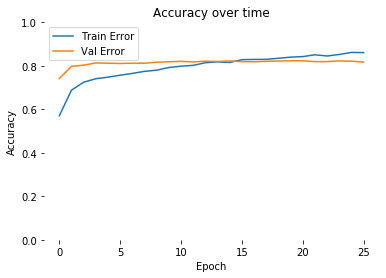

In [90]:
plot_history(history)

In [91]:
f_num

51

In [92]:
test.values[:,f_num:].shape

(3263, 100)

In [93]:
embedd_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,639,1367,53,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,278,154,1223,1729,541,1340,150,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,83,2,708,2645,16341,4557,769,560,253,0,...,0,0,0,0,0,0,0,0,0,0
3,271,3251,5619,1241,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,121,597,261,227,1165,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,154,752,1959,2361,752,19917,19918,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,16,5912,1108,58,178,89,772,4559,185,3232,...,0,0,0,0,0,0,0,0,0,0
3260,667,443,341,721,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,4156,517,323,81,1663,1796,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
predict = model4.predict([test.values[:,:f_num],embedd_test.values])
predict=np.round(predict).astype(int).reshape(3263)
submit = pd.read_csv('test.csv', usecols= ['id'])
submit['target'] = predict
submit.to_csv('submits/submit9.csv',index=False)

In [95]:
submit['target'].value_counts()

0    2126
1    1137
Name: target, dtype: int64